In [57]:
# 서부 지역 시각화 
# 1 일/공휴일 오픈 약국 지역 시각화
# 2 토요일 + 일/공휴일 오픈 약국 시간 시각화

In [58]:
# pip install folium

In [59]:
# pip install geopy

In [60]:
# pip install osmnx

In [3]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import folium

from geopy.geocoders import Nominatim
import osmnx as ox 

import seaborn as sns

In [4]:
pharmacy_list = pd.read_csv("서울특별시_약국_목록.csv")
pharmacy_list

,NO,약국명,대표전화,주소,월요일 운영,화요일 운영,수요일 운영,목요일 운영,금요일 운영,토요일 운영,일요일 운영,공휴일 운영
0,1,진메디칼약국,02-400-9240,"서울특별시 송파구 마천로57길 3, 1층 (마천동)",09:00~20:00,09:00~20:00,09:00~20:00,09:00~20:00,09:00~20:00,09:00~18:00,-,-
1,2,아현종로약국,02-313-3400,"서울특별시 마포구 굴레방로9길 2, 1층 (아현동)",09:00~21:00,09:00~21:00,09:00~21:00,09:00~21:00,09:00~21:00,09:00~17:00,-,-
2,3,연세우리약국,02-2293-1339,"서울특별시 성동구 왕십리로 296-1, 조흥은행 (행당동)",09:00~21:00,09:00~21:00,09:00~21:00,09:00~21:00,09:00~19:00,09:00~13:00,09:00~21:00,09:00~21:00
3,4,아이사랑약국,02-802-1007,서울특별시 금천구 시흥대로 214 401호,09:00~21:00,09:00~21:00,09:00~21:00,09:00~18:00,09:00~21:00,09:00~17:00,10:00~16:00,-
4,5,경일약국,02-802-9104,"서울특별시 금천구 시흥대로72길 32, (시흥동)",09:00~21:00,09:00~21:00,09:00~21:00,09:00~21:00,09:00~21:00,09:00~21:00,-,-
...,...,...,...,...,...,...,...,...,...,...,...,...
4925,4926,전진상약국,02-802-9314,"서울특별시 금천구 탑골로3가길 22, (시흥동)",14:00~18:00,14:00~18:00,14:00~18:00,14:00~18:00,14:00~18:00,-,-,-
4926,4927,조아약국,02-919-8575,"서울특별시 성북구 화랑로 87, 1층 (하월곡동)",08:30~09:00,08:30~09:00,08:30~09:00,08:30~09:00,08:30~09:00,08:30~18:00,-,-
4927,4928,해오름약국,02-545-7617,"서울특별시 강남구 봉은사로73길 5, 1층 (삼성동)",10:00~18:00,10:00~18:00,10:00~18:00,10:00~18:00,10:00~18:00,-,-,-
4928,4929,메디팜보배약국,02-461-5666,"서울특별시 성동구 아차산로7길 19, (성수동2가)",11:00~18:00,11:00~18:00,11:00~18:00,11:00~18:00,11:00~18:00,09:00~20:00,-,-


In [5]:
# 서부 지역 약국 목록 추출
count = 1
count_arr = []
split = []
west_pharmacy_num = []

pharmacy_list_address = pharmacy_list.iloc[:,3]

# 서부 지역 약국의 번호 추출
for i in range(len(pharmacy_list_address)):
    split = pharmacy_list_address[i].split()
    if split[1] == "강서구" or split[1] == "양천구" or split[1] == "구로구" or split[1] == "영등포구" or split[1] == "금천구" :
        west_pharmacy_num.append(count)
    count += 1

west_pharmacy = []

# 추출한 번호를 토대로 그 번호에 해당되는 데이터를 west_pharmacy에 append
for j in west_pharmacy_num:
    west_pharmacy.append(pharmacy_list.iloc[j-1])
#print(west_pharmacy)

In [64]:
#############################################
#
#
# 1 일/공휴일 오픈 약국 지역 시각화
#
#
#############################################

In [10]:
# 특정 요일에 오픈하는 약국의 list를 반환
def getSpecificOpenDayList(pharmacyList, dayIndex):
    openPharmacyList = []
    
    for i in range(len(pharmacyList)):
        if pharmacyList[i][dayIndex] != "-":
            openPharmacyList.append(pharmacyList[i])
    
    return openPharmacyList

In [5]:
# 도로명 주소, 역 이름 등을 좌표로 변환해 준다
# https://anweh.tistory.com/42
geolocoder = Nominatim(user_agent = 'South Korea')

def geocoding(address): 
    geo = geolocoder.geocode(address)
    crd = (geo.latitude, geo.longitude)
    return crd

In [6]:
# 특정 요일 오픈 지점의 주소를 좌표로 변환 후 저장
def getGCS(pharmacyList):
    open_address = []
    open_address_split = []
    open_GCS = []
    temp = []

    for i in range(len(pharmacyList)):
        open_address.append(pharmacyList[i][3])

    for i in open_address:
        temp = i.split()
        temp_add = temp[0]+' '+temp[1]+' '+temp[2]+' '+temp[3]
        open_address_split.append(temp_add)
    # print(west_sunday_open_address_split)

    for i in open_address_split:
        try:
            crd = geocoding(i)
            open_GCS.append(list(crd))
        except:
            pass
    
    return open_GCS

In [7]:
# 구한 좌표의 평균값 계산 -> 추후 Map으로 표현할때 사용
def getAvgGCS(openPharmacyGCS):
    sum1, sum2 = 0, 0

    for i in range(len(openPharmacyGCS)):
        sum1 += openPharmacyGCS[i][0]
        sum2 += openPharmacyGCS[i][1]

    average_long = sum1/len(openPharmacyGCS)
    average_lang = sum2/len(openPharmacyGCS)
    
    return average_long,average_lang

In [8]:
# 구한 좌표를 토대로 지도에 표현
def showMap(openPharmacyGCS):
    average_long,average_lang = getAvgGCS(openPharmacyGCS)
    
    map = folium.Map(location = [average_long,average_lang], zoom_start =11)

    for i in west_sunday_open_GCS:
        latitude = i[0]
        longtitude = i[1]
        tooltip = "Pharmacy"
        folium.Marker([latitude, longtitude], popup = '<i>위험</i>', tooltip =tooltip).add_to(map)
    return map

In [70]:
#############################################
#
#
# 2 토요일 + 일/공휴일 오픈 약국 시간 시각화
#
#
#############################################

In [6]:
# 특정 요일의 오픈 시간을 추출
def getOpenTime(openPharmacyList, dayIndex):
    open_hour = []

    for i in range(len(openPharmacyList)):
        open_hour.append(openPharmacyList[i][dayIndex])
    
    return open_hour

In [7]:
def getStartEndTimeInt(openPharmacyList):
    openTime = []

    for i in openPharmacyList:
        tmp = i.split('~')
        openTime.append(tmp)
    
    return openTime

In [22]:
%matplotlib inline

def showOpenTimeGraph(openTime,openHour,closeHour):
    plt.figure(figsize=(15,10))
    plt.rc("axes", unicode_minus=False)
    
    df_oc = pd.crosstab(openTime[openHour], openTime[closeHour])
    heat = sns.heatmap(df_oc, annot=True, fmt=".0f", cmap="Blues")
    heat.set_yticklabels(heat.get_yticklabels(), rotation=0, horizontalalignment='right')
    return plt.show()

In [74]:
# 1 일/공휴일 오픈 약국 지역 시각화

In [75]:
# 토요일 오픈 지점
west_saturday_open = getSpecificOpenDayList(west_pharmacy, 9)
west_saturday_open_GCS = getGCS(west_saturday_open)
showMap(west_saturday_open_GCS)

In [76]:
# 일요일 오픈 지점
west_sunday_open = getSpecificOpenDayList(west_pharmacy, 10)
west_sunday_open_GCS = getGCS(west_sunday_open)
showMap(west_sunday_open_GCS)

In [77]:
# 공휴일 오픈 지점
west_holiday_open = getSpecificOpenDayList(west_pharmacy, 11)
west_holiday_open_GCS = getGCS(west_holiday_open)
showMap(west_holiday_open_GCS)

In [78]:
# 2 토요일 + 일/공휴일 오픈 약국 시간 시각화

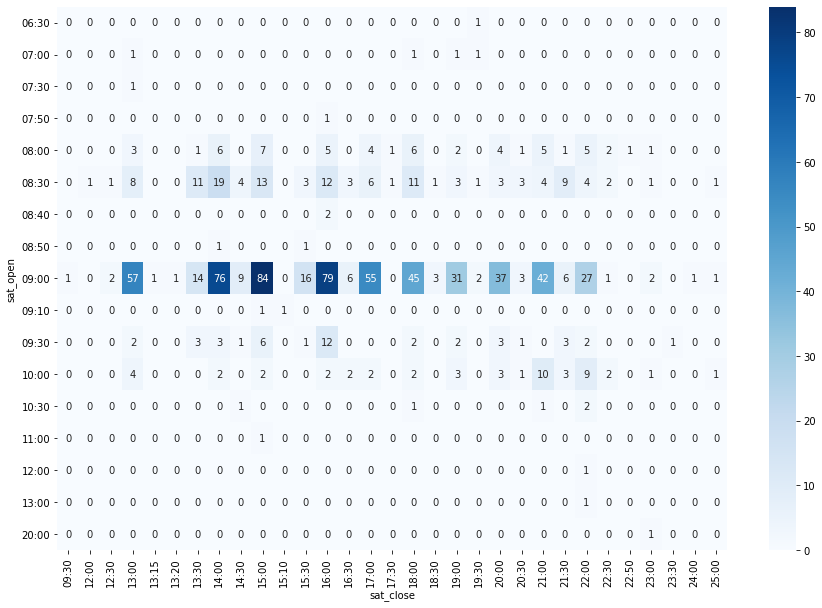

In [23]:
# 토요일 오픈 지점
temp = []
west_saturday_open = getSpecificOpenDayList(west_pharmacy, 9)
west_saturday_open_hour = getOpenTime(west_saturday_open, 9)
openTime = getStartEndTimeInt(west_saturday_open_hour)
column_name = ['sat_open', 'sat_close']
new_dataframe = pd.DataFrame(openTime, columns=column_name)
showOpenTimeGraph(new_dataframe,'sat_open', 'sat_close')

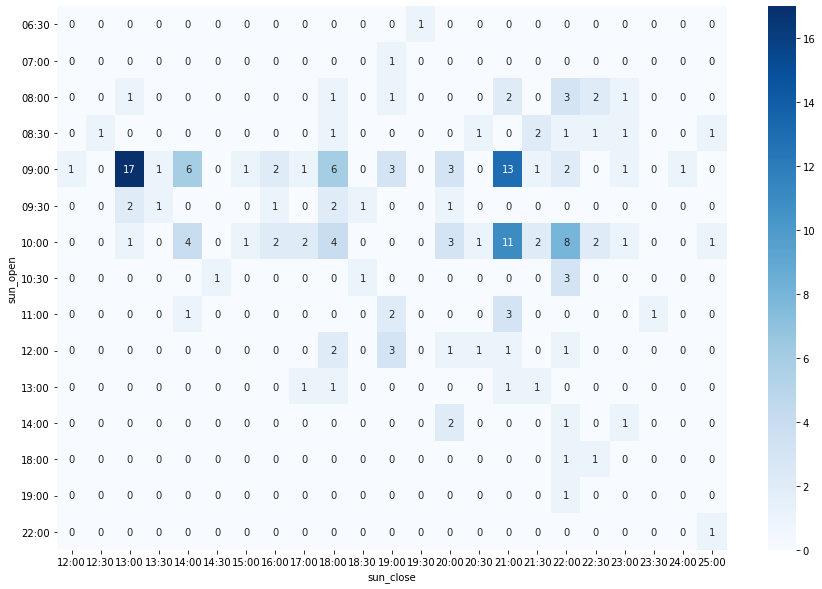

In [24]:
# 일요일 오픈 지점
west_sunday_open = getSpecificOpenDayList(west_pharmacy, 10)
west_sunday_open_hour = getOpenTime(west_sunday_open, 10)
openTime = getStartEndTimeInt(west_sunday_open_hour)
column_name = ['sun_open', 'sun_close']
new_dataframe = pd.DataFrame(openTime, columns=column_name)
showOpenTimeGraph(new_dataframe,'sun_open', 'sun_close')

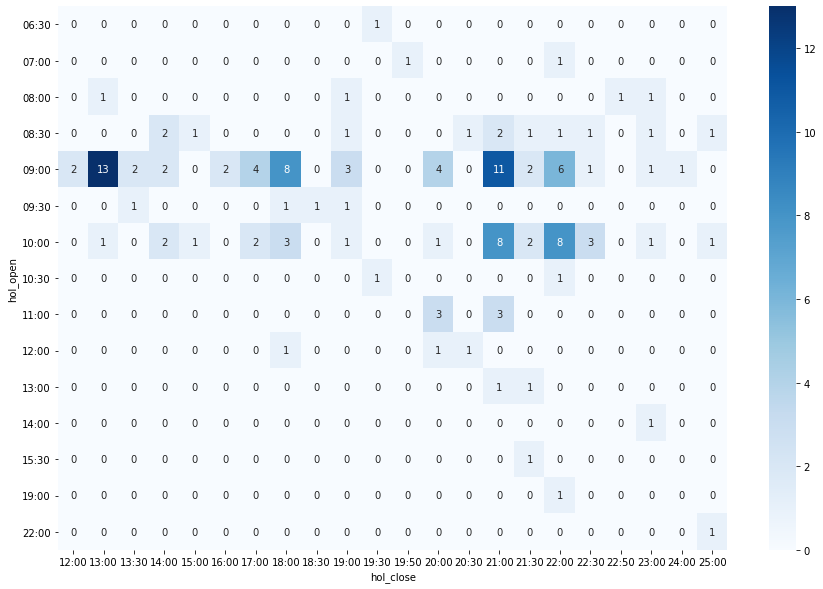

In [25]:
# 공휴일 오픈 지점
west_holiday_open = getSpecificOpenDayList(west_pharmacy, 11)
west_holiday_open_hour = getOpenTime(west_holiday_open, 11)
openTime = getStartEndTimeInt(west_holiday_open_hour)
column_name = ['hol_open', 'hol_close']
new_dataframe = pd.DataFrame(openTime, columns=column_name)
showOpenTimeGraph(new_dataframe,'hol_open', 'hol_close')